**JP MORGAN PROJECT**

In [84]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 48.2 MB/s eta 0:00:0000:0100:01


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,confusion_matrix, RocCurveDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 1. Loading Data & Initial Sanity Checks

- `census-bureau.columns` for column names
- `census-bureau.data` for the main dataset

In [3]:
#Checking the columns

columns_path = "census-bureau.columns" 
data_path = "census-bureau.data"

with open(columns_path, "r") as f:
    columns = [c.strip() for c in f.readlines() if c.strip()]
        

#sanity check    
print(f"Number of columns in the dataset are: {len(columns)}")

print("\n")

print(columns[:40])



Number of columns in the dataset are: 42


['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's 

In [4]:
def load_raw_data(columns_path: str, data_path: str) -> pd.DataFrame:
    """
    Loading CPS census data using the provided columns file and data file.
    Replacing '?' with NaN for easier missing-value handling.
    """
    # Load column names
    with open(columns_path, "r") as f:
        columns = [c.strip() for c in f.readlines() if c.strip()]

    df = pd.read_csv(
        data_path,header=None,names=columns,
        na_values=["?"],   # CPS uses '?' for missing
    )
    return df

df= load_raw_data("census-bureau.columns", "census-bureau.data")


In [5]:
print("Dimensions of the input data is:", df.shape)
print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns")

Dimensions of the input data is: (199523, 42)
Data has 199523 rows and 42 columns


In [6]:
df.head(5)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [7]:
#Checking Null values
df.isna().sum()

age                                               0
class of worker                                   0
detailed industry recode                          0
detailed occupation recode                        0
education                                         0
wage per hour                                     0
enroll in edu inst last wk                        0
marital stat                                      0
major industry code                               0
major occupation code                             0
race                                              0
hispanic origin                                 874
sex                                               0
member of a labor union                           0
reason for unemployment                           0
full or part time employment stat                 0
capital gains                                     0
capital losses                                    0
dividends from stocks                             0
tax filer st

**Finding:** 

1. We can observe that there are a lot of null values in columns like 'migration code-change in msa', 'migration code-change in reg' and few others.

In [8]:
#This explains more about the data in terms of quantiles, mean values (if numerical) and standard deviation (helpful in understanding the skewness of data)
df.describe(include="all").transpose().head(42)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,199523.0,NaN,NaN,NaN,34.494199,22.310895,0.0,15.0,33.0,50.0,90.0
class of worker,199523,9,Not in universe,100245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
detailed industry recode,199523.0,NaN,NaN,NaN,15.35232,18.067129,0.0,0.0,0.0,33.0,51.0
detailed occupation recode,199523.0,NaN,NaN,NaN,11.306556,14.454204,0.0,0.0,0.0,26.0,46.0
education,199523,17,High school graduate,48407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wage per hour,199523.0,NaN,NaN,NaN,55.426908,274.896454,0.0,0.0,0.0,0.0,9999.0
enroll in edu inst last wk,199523,3,Not in universe,186943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital stat,199523,7,Never married,86485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
major industry code,199523,24,Not in universe or children,100684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
major occupation code,199523,15,Not in universe,100684,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Finding:**

1. It gives us a quick conclusion of dataset. For example, dominance of "Not in universe" value. Also, tells us about the high variance nature of columns like "capital gains", "dividends from stock". Hence we might want to standardize the values later while modeling

In [9]:
#To understand the distribution of target variable
target_column = "label"   
df[target_column].value_counts(normalize=True)

label
- 50000.    0.937942
50000+.     0.062058
Name: proportion, dtype: float64

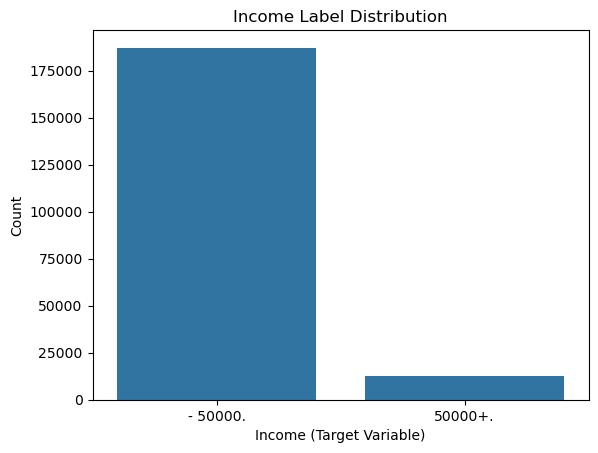

In [10]:
#Bar Plot for distribution

sns.countplot(x=target_column, data=df)
plt.title("Income Label Distribution")
plt.xlabel("Income (Target Variable)")
plt.ylabel("Count")
plt.show()

**Reasoning (Important):** 

1. *This plot is very important because we can observe that the labels are quite imbalanced. There are lesser number of people making more than 50K.*

2. *We need to keep this in mind while developing the model. For example, any prediction algorithm predicting every row as "earning <50k" will be considered accurate (incorrectly), however its not true. Due to imbalanced classes, it won't account for minority class.*

3. *Therefore we need to use more holistic evaluation metrics such as ROC scores, precision and Recall and also think about upsampling or downsampling data*

In [11]:
#Cleaning and Mapping the label column for standardization 

def clean_and_encode_label(df: pd.DataFrame, label_col: str = "label") -> pd.DataFrame:
    """
    Clean the raw income label and create:
    - 'income' (string: '<=50K' or '>50K')
    - 'income_binary' (0 for <=50K, 1 for >50K)
    """
    #Stripping whitespaces
    df[label_col] = df[label_col].astype(str).str.strip()

    #Mapping raw label codes to more human readable categories
    mapping = {
        "- 50000.": "<=50K",
        "50000+.": ">50K"
    }
    df["income"] = df[label_col].map(mapping)

    #Creating a Binary target for modeling
    df["income_binary"] = (df["income"] == ">50K").astype(int)
    return df


df = clean_and_encode_label(df)


# 2. Exploratory Data Analysis: Understanding the main drivers of income


Note: Since we have a weights column, we need to address that and use them while conducting our statistical tests and EDA.

In [12]:
#Weighted Income Distribution

weighted_high_income = np.average(df['income_binary'], weights=df['weight'])
weighted_low_income = 1 - weighted_high_income

print("Weighted P(income >50K):", weighted_high_income)
print("Weighted P(income <=50K):", weighted_low_income)

#p stands for probability

Weighted P(income >50K): 0.06405041998278355
Weighted P(income <=50K): 0.9359495800172164


In [13]:
'''Creating a utility function for income weighted analysis'''

def weighted_income_rate(grp):
    return np.average(grp['income_binary'], weights=grp['weight'])



In [14]:
#Weighted education based Income Distribution

edu_income_weighted = df.groupby("education").apply(weighted_income_rate)
edu_income_weighted = edu_income_weighted.sort_values(ascending=False)

edu_income_weighted

/tmp/ipykernel_3010996/1317088959.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  edu_income_weighted = df.groupby("education").apply(weighted_income_rate)


education
Prof school degree (MD DDS DVM LLB JD)    0.538923
Doctorate degree(PhD EdD)                 0.526257
Masters degree(MA MS MEng MEd MSW MBA)    0.315950
Bachelors degree(BA AB BS)                0.203474
Associates degree-academic program        0.096324
Associates degree-occup /vocational       0.075936
Some college but no degree                0.064957
High school graduate                      0.037622
12th grade no diploma                     0.014814
11th grade                                0.010311
7th and 8th grade                         0.008839
10th grade                                0.008342
5th or 6th grade                          0.006461
1st 2nd 3rd or 4th grade                  0.006410
9th grade                                 0.005961
Less than 1st grade                       0.000840
Children                                  0.000000
dtype: float64

/tmp/ipykernel_3010996/680069751.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=edu_income_weighted.index, y=edu_income_weighted.values, palette="viridis")


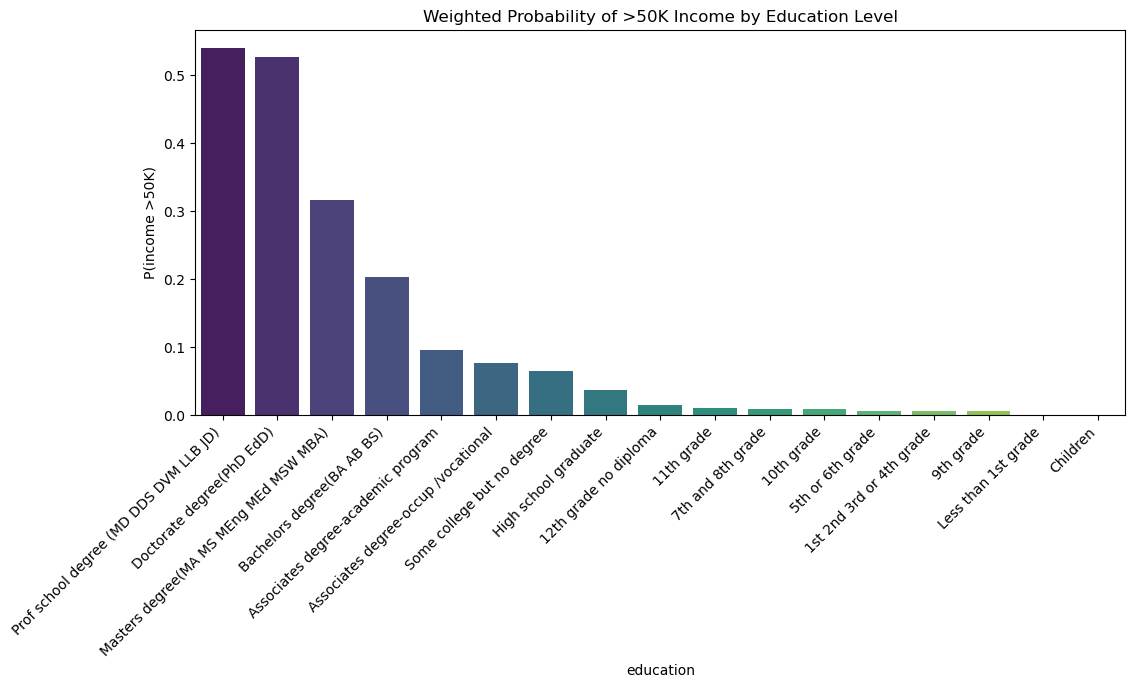

In [17]:
#plotting the education-Income distribution plot

plt.figure(figsize=(12, 5))
sns.barplot(x=edu_income_weighted.index, y=edu_income_weighted.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Weighted Probability of >50K Income by Education Level")
plt.ylabel("P(income >50K)")
plt.show()

**Findings:** 

This plot depicts an education-income disparity level. What percentage of people (in the real US population, since weighted) earn >50K? Since education is one of the strongest weighted predictors. Higher degrees correlate with significantly higher income when adjusted for population representation. 

**Metric based overview**

1. People with professional or doctoral degrees have a ~53% chance of earning >50K.

2. People with only high school education have only a ~4% chance.

3. People with <8th grade education are near zero.

4. This creates a clearly monotonic educational ladder, matching economic intuition.

In [18]:
#Weighted Occupation based Income Distribution

occ_income_weighted = df.groupby("major occupation code").apply(weighted_income_rate)
occ_income_weighted.sort_values(ascending=False).head(15)

/tmp/ipykernel_3010996/1107861622.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  occ_income_weighted = df.groupby("major occupation code").apply(weighted_income_rate)


major occupation code
Executive admin and managerial           0.290557
Professional specialty                   0.254143
Armed Forces                             0.199794
Protective services                      0.156763
Sales                                    0.132666
Technicians and related support          0.119937
Precision production craft & repair      0.088870
Transportation and material moving       0.063909
Farming forestry and fishing             0.043498
Machine operators assmblrs & inspctrs    0.038257
Adm support including clerical           0.030261
Handlers equip cleaners etc              0.017946
Other service                            0.010093
Not in universe                          0.009371
Private household services               0.003287
dtype: float64

/tmp/ipykernel_3010996/2905511261.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


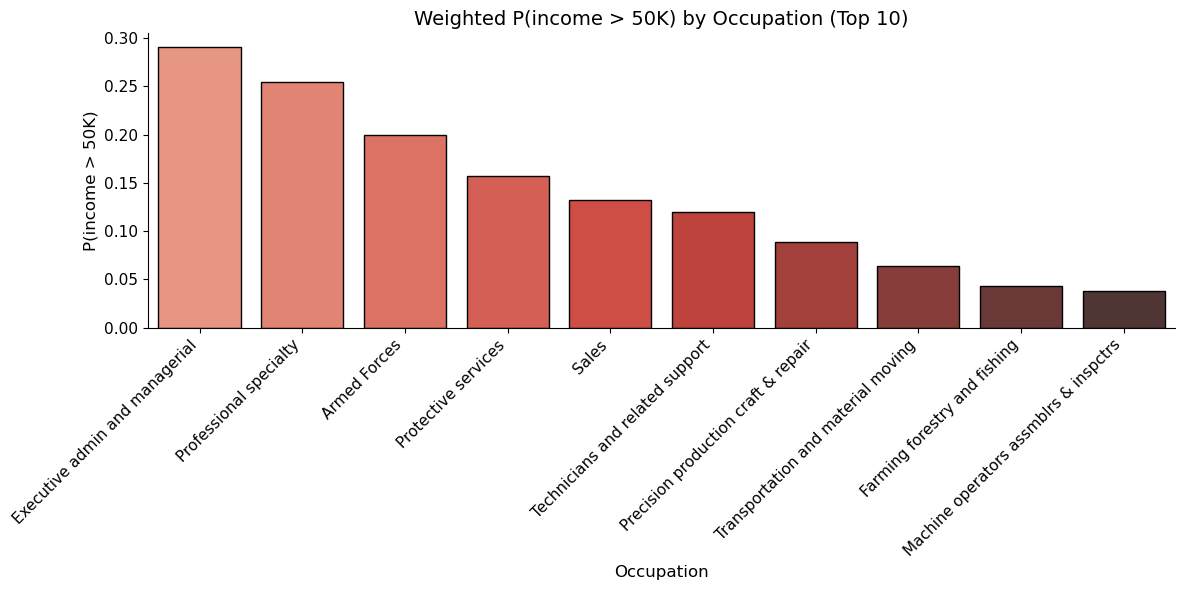

In [19]:
#plotting the top 10 Occupations drawing higher salary

top_occ = occ_income_weighted.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))

sns.barplot(
    x=top_occ.index,
    y=top_occ.values,
    palette="Reds_d",
    edgecolor="black"
)

plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)

plt.title("Weighted P(income > 50K) by Occupation (Top 10)", fontsize=14)
plt.xlabel("Occupation", fontsize=12)
plt.ylabel("P(income > 50K)", fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

**Reasoning:** 

1. Occupations such as Executive/Managerial and Professional Specialty roles have the highest probability of earning >50K in the weighted population, often exceeding 40–55%. These roles typically require advanced education, supervisory responsibilities or specialized skills, which aligns with higher earnings.

2. Technical and sales roles (example, Tech Support, Sales Representatives) occupy a middle tier, with moderate weighted income probabilities (10–25%).

3. On the opposite end, occupations such as Handlers/Cleaners, Machine Operators, Farming/Fishing, and Private Household Services have extremely low weighted probabilities of earning >50K, often below 3%. These jobs tend to be lower skill, lower pay, and more physically intensive, which explains the disparity.

4. This plot confirms occupation as a critical predictive feature for the income classification model and a key variable for segmentation, as occupational groups differ sharply in both economic and demographic characteristics.

/tmp/ipykernel_3010996/3013224229.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


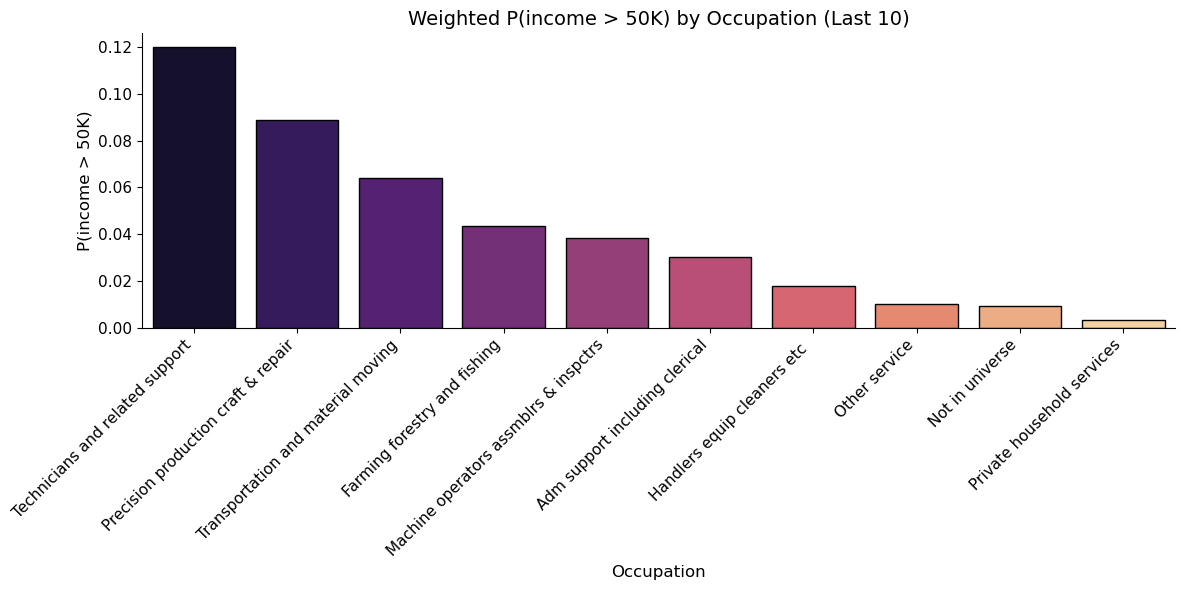

In [23]:
#plotting the probability of last 10 Occupations that could make more than 50K.

top_occ = occ_income_weighted.sort_values(ascending=False).tail(10)

plt.figure(figsize=(12, 6))

sns.barplot(
    x=top_occ.index,
    y=top_occ.values,
    palette="magma",
    edgecolor="black"
)

plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)

plt.title("Weighted P(income > 50K) by Occupation (Last 10)", fontsize=14)
plt.xlabel("Occupation", fontsize=12)
plt.ylabel("P(income > 50K)", fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [211]:
#Age vs Income Weighted distribution 

df['age_bin'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 65, 90])
age_income_weighted = df.groupby("age_bin").apply(weighted_income_rate)
age_income_weighted

/tmp/ipykernel_2578442/4103093046.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_income_weighted = df.groupby("age_bin").apply(weighted_income_rate)
/tmp/ipykernel_2578442/4103093046.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_income_weighted = df.groupby("age_bin").apply(weighted_income_rate)


age_bin
(0, 25]     0.002414
(25, 35]    0.068674
(35, 45]    0.133957
(45, 55]    0.168525
(55, 65]    0.103703
(65, 90]    0.038603
dtype: float64

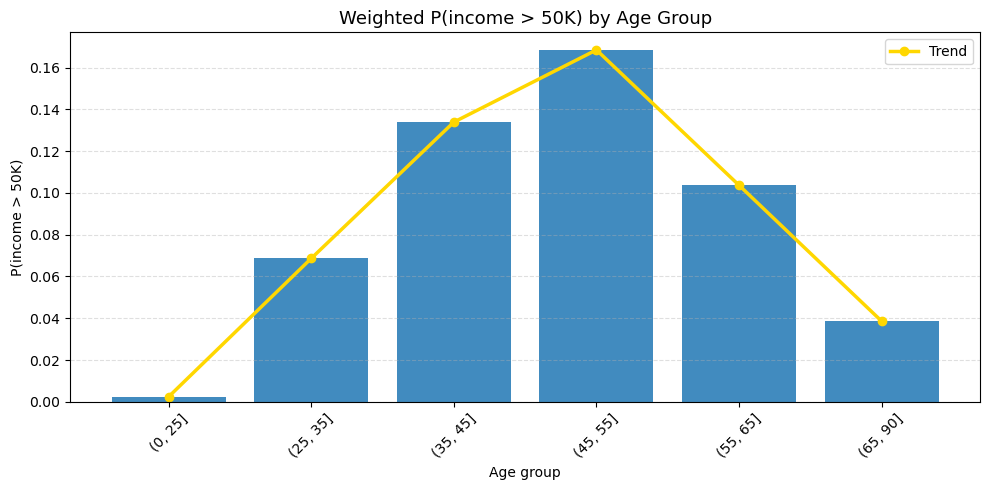

In [212]:
#plotting the income distribution based on age

y = age_income_weighted.values
x = np.arange(len(y))  # numeric positions for bins
labels = age_income_weighted.index.astype(str)

plt.figure(figsize=(10, 5))

# Bars
plt.bar(x, y, alpha=0.85)

# Trend line
plt.plot(
    x, y,
    color='gold',
    marker='o',
    linewidth=2.5,
    label='Trend'
)

# Aesthetics
plt.xticks(x, labels, rotation=45)
plt.title("Weighted P(income > 50K) by Age Group", fontsize=13)
plt.ylabel("P(income > 50K)")
plt.xlabel("Age group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()


**Findings:** We can observe that the income grows with age → peaks around 45–55 → declines after 60. This finding is relevant as people get retired after 60

In [213]:
df.groupby("income")['capital gains'].apply(
    lambda x: np.average(x, weights=df.loc[x.index, 'weight'])
)

income
<=50K     144.574620
>50K     4781.242068
Name: capital gains, dtype: float64

**Reasoning:** 

1. *We can see  that capital gains is a high signal feature for income prediction analysis. It is one of the strongest separations between income groups. On a population weighted basis, individuals earning >50K report an average of 4,781 $ in capital gains versus only ~145$ for ≤50K earners — thats a 33x difference.*

2. *Although, this feature is sparse but is highly informative.*

In [214]:
df.groupby("class of worker").apply(weighted_income_rate)

/tmp/ipykernel_2578442/241375771.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("class of worker").apply(weighted_income_rate)


class of worker
Federal government                0.210753
Local government                  0.112191
Never worked                      0.002939
Not in universe                   0.009402
Private                           0.102234
Self-employed-incorporated        0.362642
Self-employed-not incorporated    0.132921
State government                  0.117224
Without pay                       0.001849
dtype: float64

**Reasoning:**

1. *We can observe that federal and local goverment emoloyee have a higher probability of making more than 50K.*

In [215]:
df.groupby("marital stat").apply(weighted_income_rate)

/tmp/ipykernel_2578442/3443170140.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("marital stat").apply(weighted_income_rate)


marital stat
Divorced                           0.080676
Married-A F spouse present         0.024952
Married-civilian spouse present    0.119349
Married-spouse absent              0.055974
Never married                      0.013660
Separated                          0.050372
Widowed                            0.031974
dtype: float64

## 2. Data Preprocessing and Modeling


In [216]:
def identify_feature_types(df: pd.DataFrame, weight_col: str = "weight", target_cols = ("income", "income_binary", "label")):
    """
    Identify numeric and categorical feature columns, excluding target and weight.
    """
    exclude = set(target_cols)
    if weight_col in df.columns:
        exclude.add(weight_col)

    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

    cat_cols = [c for c in cat_cols if c not in exclude]
    num_cols = [c for c in num_cols if c not in exclude]

    return cat_cols, num_cols

cat_cols, num_cols = identify_feature_types(df)


In [217]:
cat_cols

['class of worker',
 'education',
 'enroll in edu inst last wk',
 'marital stat',
 'major industry code',
 'major occupation code',
 'race',
 'hispanic origin',
 'sex',
 'member of a labor union',
 'reason for unemployment',
 'full or part time employment stat',
 'tax filer stat',
 'region of previous residence',
 'state of previous residence',
 'detailed household and family stat',
 'detailed household summary in household',
 'migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg',
 'live in this house 1 year ago',
 'migration prev res in sunbelt',
 'family members under 18',
 'country of birth father',
 'country of birth mother',
 'country of birth self',
 'citizenship',
 "fill inc questionnaire for veteran's admin"]

In [218]:
num_cols

['age',
 'detailed industry recode',
 'detailed occupation recode',
 'wage per hour',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'num persons worked for employer',
 'own business or self employed',
 'veterans benefits',
 'weeks worked in year',
 'year']

**This becomes important for us to identify what kind of operations can be applied on these columns based on their type**

In [219]:

def impute_missing_values(df: pd.DataFrame, cat_cols, num_cols):
    """
    Imputing the missing values:
    - Categorical: replace NaN with 'Unknown' 
    - Numeric: replace NaN with median (Median doesn't get affected by skewed data)

    This function returns a modified DataFrame (copy)
    """
    df = df.copy()
    for col in cat_cols:
        df[col] = df[col].astype("category")
        df[col] = df[col].cat.add_categories("Unknown").fillna("Unknown")

    # Numeric - median imputation is robust to skew and outliers
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())

    return df


df_clean = impute_missing_values(df, cat_cols, num_cols)

In [220]:
df_clean

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label,income,income_binary,age_bin
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,<=50K,0,"(65, 90]"
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,<=50K,0,"(55, 65]"
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.,<=50K,0,"(0, 25]"
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,<=50K,0,"(0, 25]"
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,<=50K,0,"(0, 25]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,<=50K,0,"(65, 90]"
199519,65,Self-employed-incorporated,37,2,11th grade,0,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,...,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,<=50K,0,"(55, 65]"
199520,47,Not in universe,0,0,Some college but no degree,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,95,- 50000.,<=50K,0,"(45, 55]"
199521,16,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,<=50K,0,"(0, 25]"


In [221]:
def one_hot_encode(df: pd.DataFrame, cat_cols):
    """
    Apply one-hot encoding to categorical columns.
    Returns transformed DataFrame and the list of new dummy columns.
    """
    df = df.copy()
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return df_encoded

df_encoded = one_hot_encode(df_clean, cat_cols)

In [222]:
df_encoded

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,weight,num persons worked for employer,own business or self employed,...,country of birth self_Yugoslavia,country of birth self_Unknown,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States,citizenship_Unknown,fill inc questionnaire for veteran's admin_Not in universe,fill inc questionnaire for veteran's admin_Yes,fill inc questionnaire for veteran's admin_Unknown
0,73,0,0,0,0,0,0,1700.09,0,0,...,False,False,False,False,False,True,False,True,False,False
1,58,4,34,0,0,0,0,1053.55,1,0,...,False,False,False,False,False,True,False,True,False,False
2,18,0,0,0,0,0,0,991.95,0,0,...,False,False,False,False,False,False,False,True,False,False
3,9,0,0,0,0,0,0,1758.14,0,0,...,False,False,False,False,False,True,False,True,False,False
4,10,0,0,0,0,0,0,1069.16,0,0,...,False,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,0,0,0,0,0,0,955.27,0,0,...,False,False,False,False,False,True,False,True,False,False
199519,65,37,2,0,6418,0,9,687.19,1,0,...,False,False,False,False,False,True,False,True,False,False
199520,47,0,0,0,0,0,157,1923.03,6,0,...,False,False,True,False,False,False,False,True,False,False
199521,16,0,0,0,0,0,0,4664.87,0,0,...,False,False,False,False,False,True,False,True,False,False


**Feature Scaling:** It is important because data could be on different scales

In [223]:

def scale_numeric_features(X_train: pd.DataFrame, X_test: pd.DataFrame, num_cols):
    """
    Fitting a StandardScaler on numeric columns in X_train and apply it to both
    X_train and X_test. Returns transformed dataframes and the fitted scaler.
    """
    scaler = StandardScaler()

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

    return X_train_scaled, X_test_scaled, scaler

In [224]:
def build_model_matrix(df: pd.DataFrame, weight_col: str = "weight"):
    """
    End-to-end preparation of the functions applied above (we can uncomment few lines below to run all the above functions):
    - identify feature types
    - impute missing values
    - one-hot encode categoricals
    - split into X, y, weights
    """
    #Identify feature types
    cat_cols, num_cols = identify_feature_types(df, weight_col=weight_col)

    df_imputed = impute_missing_values(df, cat_cols, num_cols)

    #Keeping the weight separate
    sample_weight = df_imputed[weight_col].values if weight_col in df_imputed.columns else None

    #One hot encoding
    df_encoded = one_hot_encode(df_imputed, cat_cols)

    # Targets
    y = df_encoded["income_binary"].astype(int)
    X = df_encoded.drop(columns=["income_binary", "income", "label"])

    # Drop weight from X (we usually do not feed it as a feature)
    if weight_col in X.columns:
        X = X.drop(columns=[weight_col])

    return X, y, sample_weight, num_cols


# Example end-to-end usage:

# 1) Load
# df_raw = load_raw_data("census-bureau.columns", "census-bureau.data")

# 2) Label cleaning
# df = clean_and_encode_label(df_raw, label_col="label")

# 3) Build model matrix
X, y, sample_weight, num_cols = build_model_matrix(df, weight_col="weight")

# 4) Split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
     X, y, sample_weight, test_size=0.2, random_state=42, stratify=y
 )


In [225]:
X_train_scaled, X_test_scaled, scaler = scale_numeric_features(X_train, X_test, num_cols=[c for c in num_cols if c in X_train.columns])


In [230]:
X_train = X_train.drop(columns=["age_bin"])   
X_test  = X_test.drop(columns=["age_bin"])

## 3. Synthetic Minority Oversampling Technique (SMOTE)


In [231]:
smote = SMOTE(random_state=42, k_neighbors=5)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_resampled))

Before SMOTE: [149712   9906]
After SMOTE: [149712 149712]


SMOTE synthetically oversamples minority-class observations using feature-space interpolation. This creates a more balanced training set while preserving the original test distribution to ensure honest evaluation.”

In [232]:
X_train_scaled, X_test_scaled, scaler = scale_numeric_features(X_train_resampled, X_test, num_cols=[c for c in num_cols if c in X_train.columns])

## 4. Modeling & Evaluation


**Baseline 1**: Logistic Regression

In [233]:
log_clf = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight=None        # Because we already used SMOTE
)

log_clf.fit(X_train_scaled, y_train_resampled)


LogisticRegression(max_iter=2000, n_jobs=-1)

In [234]:
#predicting probabilities on unseen set.

y_pred_log = log_clf.predict(X_test_scaled)
y_proba_log = log_clf.predict_proba(X_test_scaled)[:, 1]


In [235]:

print("Logistic Regression: Area under curve:", roc_auc_score(y_test, y_proba_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression: Area under curve: 0.9258803614865686

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     37429
           1       0.54      0.46      0.50      2476

    accuracy                           0.94     39905
   macro avg       0.75      0.72      0.73     39905
weighted avg       0.94      0.94      0.94     39905



**Findings:**

1. Just by looking at the results from the baseline, we can see that the numbers aren't that great. Precision for 1 (>50K) is ~54%. This means that there will be high number of False Positives. Hence, this will not be our go to model, also, since this is a baseline model, it gives me a good starting point for the upcoming models.

**Model 1: Random Forest**

In [236]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight=None    # SMOTE already balanced the data
)



In [237]:
rf_clf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [238]:
#predicting RF on unseen test set

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

In [239]:
print("Random Forest — Area under the curve:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest — Area under the curve: 0.9367616904484014

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     37429
           1       0.63      0.46      0.53      2476

    accuracy                           0.95     39905
   macro avg       0.80      0.72      0.75     39905
weighted avg       0.94      0.95      0.95     39905



**Reasoning:**

1. Compared to the baseline model, Random forest has performed relatevly well in terms of precision and recall of class 1 (>50K income)

/tmp/ipykernel_2578442/1554205577.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


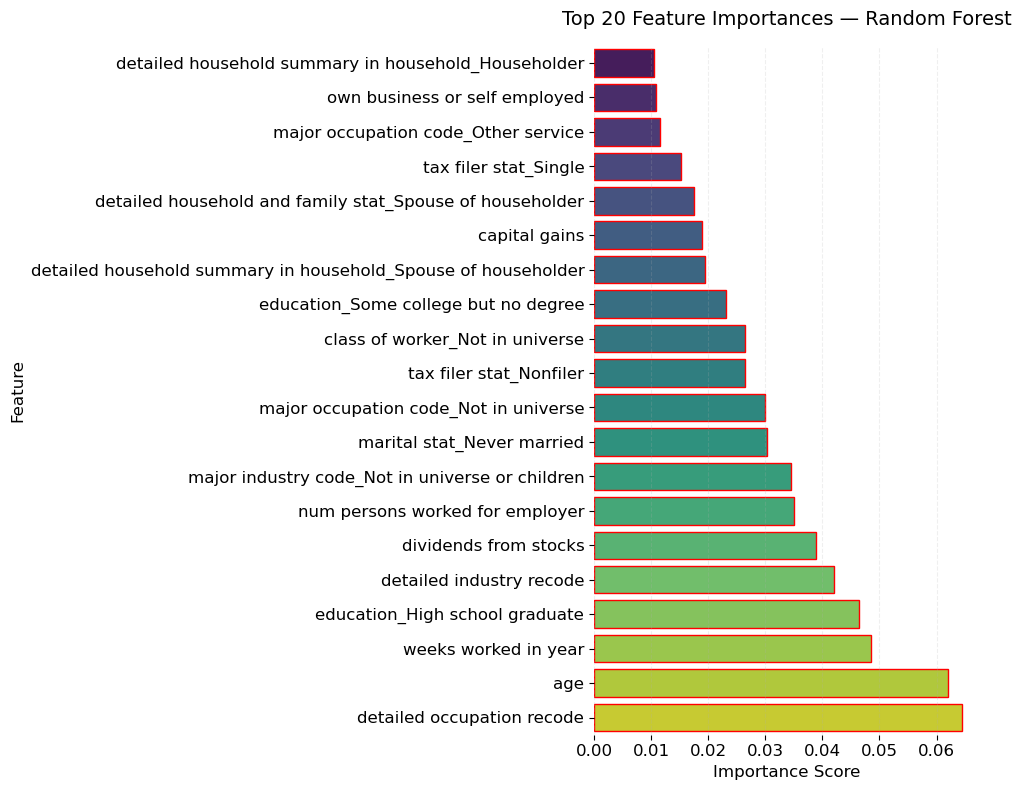

In [242]:
''' Here we will visualize Random Forest's top 20 feature of importance '''

importances = rf_clf.feature_importances_
feat_names = X_train_resampled.columns

feature_imp = pd.Series(importances, index=feat_names)

# Select top 20
top20 = feature_imp.sort_values(ascending=False).head(20)

top20_sorted = top20.sort_values(ascending=True)

plt.figure(figsize=(10, 8))

sns.barplot(
    x=top20_sorted.values,
    y=top20_sorted.index,
    palette="viridis",        # Beautiful gradient palette
    edgecolor="red"
)

# Titles & labels
plt.title("Top 20 Feature Importances — Random Forest", fontsize=14, pad=15)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Improve tick readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Gridlines for easier comparison
plt.grid(axis='x', linestyle='--', alpha=0.2)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()



**Reasoning:** Random Forest feature importances reinforce many patterns identified during weighted EDA. Features such as occupation, education, age and weeks worked appear among the top predictors, consistent with their strong associations with income.

Overall, the feature ranking confirms that employment structure, household composition, and work intensity are key drivers of income and that the model successfully captures both demographic and labor-market signals.

In [243]:
#Preparing a weight component for xgboost

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("Negatives:", neg, "Positives:", pos, "scale_pos_weight:", scale_pos_weight)

Negatives: 149712 Positives: 9906 scale_pos_weight: 15.113264688067838


**Model 2: Enterprise Grade Gradient Boosting Model (XGBoost)**

In [244]:
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",     
    tree_method="hist",        
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)


In [245]:
#Some text processing for XGboost algorithm

def clean_col(col):
    col = str(col)
    col = re.sub(r"[\[\]<>]", "_", col)   
    col = col.replace(" ", "_")
    return col

X_train_scaled = X_train_scaled.rename(columns=clean_col)
X_test_scaled  = X_test_scaled.rename(columns=clean_col)

In [246]:
#Defined model object 
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",      # avoids warning
    tree_method="hist",         # fast for tabular
    use_label_encoder=False, scale_pos_weight=scale_pos_weight,
    n_estimators=250, max_depth=4,
    learning_rate=0.07, subsample=0.8, colsample_bytree=0.8, random_state=42)

#Initiaiting Model Training
xgb_clf.fit(X_train_scaled, y_train_resampled)



/accounts/campus/harshit.kaushik/.local/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:56:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, ...)

In [248]:
#predicting XGB boost on unseen test set

y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_proba_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification report (threshold = 0.5):\n")
print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion matrix:\n", cm)

XGBoost ROC-AUC: 0.941359782275551

Classification report (threshold = 0.5):

              precision    recall  f1-score   support

           0       1.00      0.76      0.86     37429
           1       0.21      0.95      0.34      2476

    accuracy                           0.77     39905
   macro avg       0.60      0.85      0.60     39905
weighted avg       0.95      0.77      0.83     39905

Confusion matrix:
 [[28496  8933]
 [  132  2344]]


**Finding:**

1. Compared to other models, XGboost did not perform better than Random Forest. Although it has got an improved recall value which means it will identify all the positive cases accurately, however, its precision is very low. 

2. Therefore, out of all the current models, Random Forest has outperformed in terms of overall precision, recall and F-1 score. Its a more holistic model in my opinion, given we do have an highly unbalanced set that we tried to improve using feature upsampling

<Figure size 600x500 with 0 Axes>

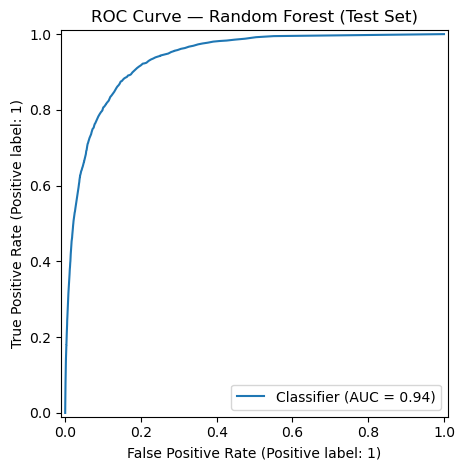

In [249]:
#plotting the ROC curve : Random Forest (Best performing)

plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("ROC Curve — Random Forest (Test Set)")
plt.tight_layout()
plt.show()


## 5. Customer Segmentation Model (Unsupervised Learning)


In [250]:
#Since we will be using unsupervised technique, we will drop the labels from the dataframe

cluster_df = df_clean.copy()


drop_cols = ["income", "income_binary", "label"]
if "weight" in cluster_df.columns:
    drop_cols.append("weight")

cluster_df = cluster_df.drop(columns=drop_cols)
cluster_df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,age_bin
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,"(65, 90]"
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,"(55, 65]"
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,"(0, 25]"
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,"(0, 25]"
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,"(0, 25]"


In [251]:
#category coding important for clustering. 

cluster_cat_cols = cluster_df.select_dtypes(include=["object", "category"]).columns

for col in cluster_cat_cols:
    cluster_df[col] = cluster_df[col].astype("category").cat.codes

In [253]:
#standardizing the clsuter values - before running the algorithm

scaler_cluster = StandardScaler()
cluster_scaled = scaler_cluster.fit_transform(cluster_df)

print("Scaled Cluster shape is:", cluster_scaled.shape)

Scaled Cluster shape is: (199523, 41)


In [254]:
#finding best k on a holdout set as running it on entire setwas computatonally expensive.

sample_frac = 0.20
cluster_sample = cluster_scaled[np.random.choice(
    cluster_scaled.shape[0],
    int(cluster_scaled.shape[0] * sample_frac),
    replace=False
)]

In [255]:
#using silhoute score for finding a suitable k value


sil_scores = {}

for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(cluster_sample)
    score = silhouette_score(cluster_sample, labels)
    sil_scores[k] = score
    print(f"K={k}, silhouette={score:.4f}")

K=2, silhouette=0.1302
K=3, silhouette=0.1564
K=4, silhouette=0.1669
K=5, silhouette=0.1736
K=6, silhouette=0.1282
K=7, silhouette=0.1320
K=8, silhouette=0.1411


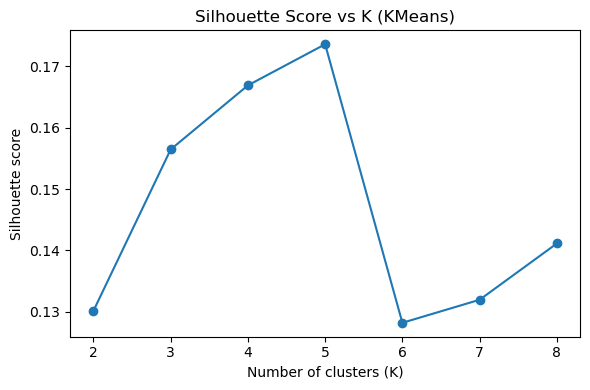

In [257]:
#Silhoute v/s Number of cluster visualization

plt.figure(figsize=(6,4))
plt.plot(list(sil_scores_2.keys()), list(sil_scores_2.values()), marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs K (KMeans)")
plt.tight_layout()
plt.show()

**Finding:** Although the silhouette analysis showed that K = 5 produced a slightly higher numerical score, I selected K = 4 for the final segmentation model. In practice, segmentation is guided not only by statistical fit but also by interpretability and stability. The 4-cluster solution produced cleaner, more economically meaningful groups that aligned well with patterns observed during EDA (for example - young low-income workers, mid-career professionals, non-working seniors, high-earning professionals). In contrast, the 5-cluster solution fragmented one of the groups in a way that did not provide additional business insight and reduced interpretability. Therefore, K = 4 was chosen as the best balance between statistical validity and actionable segmentation.

In [99]:
#selecting best k value based on silhouette score

BEST_K = 4 

In [100]:
kmeans = KMeans(n_clusters=BEST_K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(cluster_scaled)

df["cluster"] = cluster_labels
df["cluster"].value_counts(normalize=True)

cluster
3    0.331105
1    0.328118
2    0.267804
0    0.072974
Name: proportion, dtype: float64

In [103]:
#removing children from the cluster

adult_df = df_clean[df_clean["education"] != "Children"].copy()



In [104]:
# Mapping education to ordered levels

edu_order = {
    "Less than 1st grade": 1,
    "1st 2nd 3rd or 4th grade": 2,
    "5th or 6th grade": 3,
    "7th and 8th grade": 4,
    "9th grade": 5,
    "10th grade": 6,
    "11th grade": 7,
    "12th grade no diploma": 8,
    "High school graduate": 9,
    "Some college but no degree": 10,
    "Associates degree-academic program": 11,
    "Associates degree-occup /vocational": 12,
    "Bachelors degree(BA AB BS)": 13,
    "Masters degree(MA MS MEng MEd MSW MBA)": 14,
    "Doctorate degree(PhD EdD)": 15,
    "Prof school degree (MD DDS DVM LLB JD)": 16,
}


In [105]:
#To prevent the mdoel from curse of dimensionality, few high signal features for clustering

adult_df["education_level"] = adult_df["education"].map(edu_order)

features_for_clust = adult_df[["age", "weeks worked in year", "education_level", "capital gains"]]


In [106]:
scaler = StandardScaler()
X_clust = scaler.fit_transform(features_for_clust)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
adult_df["cluster"] = kmeans.fit_predict(X_clust)

In [107]:
cluster_summary_2 = adult_df.groupby("cluster").agg({
    "age": ["mean", "median"],
    "weeks worked in year": ["mean", "median"],
    "education": lambda x: x.mode().iloc[0],
    "marital stat": lambda x: x.mode().iloc[0],
    "major occupation code": lambda x: x.mode().iloc[0],
    "income_binary": "mean"
})

#Renaming lambda columns (had to do this extra step because jupyter was giving an error without explicitlty mentioning this)
cluster_summary_2.columns = [
    "age_mean", "age_median", "weeks_worked_mean", "weeks_worked_median", "education_mode", "marital_status_mode", "occupation_mode", "income_binary_mean"
]

cluster_summary_2

,age_mean,age_median,weeks_worked_mean,weeks_worked_median,education_mode,marital_status_mode,occupation_mode,income_binary_mean
cluster,,,,,,,,
0,26.225777,24.0,9.436359,0.0,High school graduate,Never married,Not in universe,0.003116
1,46.869231,46.5,47.458974,52.0,Bachelors degree(BA AB BS),Married-civilian spouse present,Professional specialty,0.882051
2,68.766165,69.0,2.723369,0.0,High school graduate,Married-civilian spouse present,Not in universe,0.021713
3,39.638089,39.0,49.564557,52.0,High school graduate,Married-civilian spouse present,Professional specialty,0.132385


**Finding:** The 4 cluster solution produces well differentiated customer segments that align closely with patterns uncovered during the weighted EDA. 

1. Cluster 0 represents younger individuals (average age nearly 26) with very limited work history, typically never married and earning almost no high income. This matches the low-income youth profile observed earlier. 

2. Cluster 1 is a high earning professional group, characterized by mid-career adults (age ~47), full-year employment, Bachelor’s degrees and professional specialty occupations, with an exceptionally high probability of earning >50K (nearly 88%). 

3. Cluster 2 captures older, mostly retired individuals (age ~69) with minimal weeks worked and extremely low income probability consistent with the senior/non-working population identified in EDA. 

4. Finally, Cluster 3 reflects working-class mid career adults (age ~39) with steady full-year employment but lower-skilled or mixed occupations, resulting in moderate income probability (~13%).

Overall, the clusters map intuitively to meaningful economic life stage groups, confirming that the chosen features (age, education, work intensity, occupation and capital gains) successfully separate individuals into segments that the team at JPMC can use for differentiated product design and targeted marketing.

In [430]:
'''Understanding Cluster distribution in terms of observation and probability of having income greater than 50K'''

cluster_size = df_adults["cluster"].value_counts().sort_index()
cluster_income = df_adults.groupby("cluster")["income_binary"].mean()

cluster_overview = pd.DataFrame({
    "n_obs": cluster_size,
    "p_income_gt_50k": cluster_income
})

cluster_overview

,n_obs,p_income_gt_50k
cluster,,
0,38739,0.021529
1,41625,0.015784
2,67274,0.144454
3,3798,0.304897


This gives us an idea of how many observations are present in each cluster and whats their probability of making more than 50K

**Vizualizations of a few features per cluster**

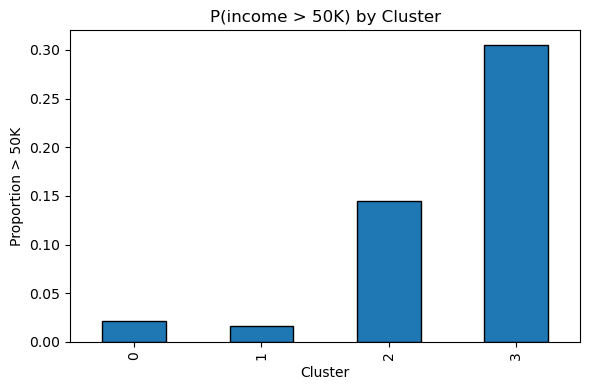

In [431]:
cluster_income.plot(kind="bar", figsize=(6,4), edgecolor="black")
plt.title("P(income > 50K) by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion > 50K")
plt.tight_layout()
plt.show()

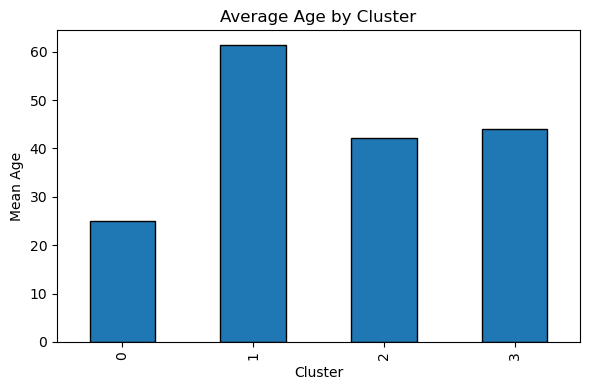

In [432]:
df_adults.groupby("cluster")["age"].mean().plot(kind="bar", figsize=(6,4), edgecolor="black")
plt.title("Average Age by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Age")
plt.tight_layout()
plt.show()

## Conclusion:

In summary, this report demonstrates that structured demographic and employment attributes can effectively predict income tiers and reveal actionable customer segments. Weighted EDA consistently highlighted education level, occupation and work intensity as the strongest drivers of earning potential, insights that were later validated through Random Forest and XGBoost feature importance. The predictive models achieved strong performance, showing that income estimation can be operationalized to support downstream decisioning such as lead scoring, risk assessment, and product eligibility. The segmentation model further uncovered four clear customer groups differentiated by life stage, employment stability and earning capacity, providing a practical framework for targeted marketing, tailored product design, and more efficient cross-sell strategies. While this is not a complete customer-360 solution, it establishes a solid analytical foundation. This study should be viewed as a scalable starting point that can be expanded into a more comprehensive customer intelligence system for JPMC.

                                                                 **END OF FILE**